In [1]:
import numpy as np
import random

In [2]:
action_map = {
    "UP": 1,
    "DOWN": 2,
    "LEFT": 3,
    "RIGHT": 4
}

In [3]:
class Maze():
    
    def __init__(self):
        self.x = 5
        self.y = 3
        self.board = np.array([
            [0,0,0,0,0,0,0,0,3],
            [0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],
            [1,1,1,1,1,1,1,1,0],
            [0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],
        ])
        self.last_reward = None
        self.term = None
        
    def step(self, action):
        rollback = (self.x, self.y)
        if action == "UP":
            self.x = np.clip(self.x-1, 0, 5)
        elif action == "DOWN":
            self.x = np.clip(self.x+1, 0, 5)
        elif action == "LEFT":
            self.y = np.clip(self.y-1, 0, 8)
        elif action == "RIGHT":
            self.y = np.clip(self.y+1, 0, 8)
        if self.board[self.x][self.y] == 1:
            self.x, self.y = rollback
            self.last_reward = 0
            self.term = False
        elif self.board[self.x][self.y] == 3:
            self.last_reward = 1
            self.term = True
        else:
            self.last_reward = 0
            self.term = False
    
    def reward(self):
        return (self.last_reward, self.term)
        
    def reset(self):
        self.x = 5
        self.y = 3
        self.last_reward = None
        self.term = None

In [9]:
class Agent():
    
    def __init__(self):
        self.t = 0
        self.watch = True
        self.env = Maze()
        
    def move(self, action):
        self.env.step(action)
        self.t+=1
        if self.t > 1000 and self.watch:
            self.env.board[3][0] = 0
            self.env.board[3][8] = 1
            self.watch = False
    
    def reward(self):
        return self.env.reward()
    
    def reset(self):
        self.env.reset()
        
    def dyna(self):
        steps = 3000
        cumrew = 0
        plot_data = []
        n = 250
        epsilon = 0.1
        gamma = 0.95
        lr = 0.1
        q = {(x, y, a) : 0 for x in range(6) for y in range(9) for a in action_map.keys()}
        m = {(x, y, a) : np.nan for x in range(6) for y in range(9) for a in action_map.keys()}
        o = {(x, y) : [] for x in range(6) for y in range(9)}
        for step in range(steps):
            plot_data.append(cumrew)
            x = self.env.x
            y = self.env.y
            a = np.random.choice(
                [max(list(action_map.keys()), key = lambda a: q[(x, y, a)]), random.choice(list(action_map.keys()))], 
                p=[1-epsilon, epsilon]
            )
            self.move(a)
            r, term = self.reward()
            o[(x, y)].append(a)
            x_new = self.env.x
            y_new = self.env.y
            q[(x,y,a)] = q[(x,y,a)] + lr * (r + gamma * q[(x_new, y_new, max(list(action_map.keys()), key = lambda a: q[(x_new, y_new, a)]))] - q[(x,y,a)])
            m[(x,y,a)] = (r, x_new, y_new)
            if term:
                cumrew+=1
                self.reset()
                continue
            for n in range(n):
                x, y = random.choice(list(key for key in o.keys() if len(o[key])>0))
                a = random.choice(o[(x, y)])
                r, x_new, y_new = m[(x, y, a)]
                q[(x,y,a)] = q[(x,y,a)] + lr * (r + gamma * q[(x_new, y_new, max(list(action_map.keys()), key = lambda a: q[(x_new, y_new, a)]))] - q[(x,y,a)])
        return plot_data, q
    
    def dynaplus(self, n = 250, k = 0.001):
        steps = 3000
        cumrew = 0
        plot_data = []
        epsilon = 0.1
        gamma = 0.95
        lr = 0.1
        q = {(x, y, a) : 0 for x in range(6) for y in range(9) for a in action_map.keys()}
        m = {(x, y, a) : (0, x, y) for x in range(6) for y in range(9) for a in action_map.keys()}
        h = {(x, y, a) : 0 for x in range(6) for y in range(9) for a in action_map.keys()}
        o = {(x, y) : [] for x in range(6) for y in range(9)}
        for step in range(steps):
            plot_data.append(cumrew)
            x = self.env.x
            y = self.env.y
            a = np.random.choice(
                [max(list(action_map.keys()), key = lambda a: q[(x, y, a)]), random.choice(list(action_map.keys()))], 
                p=[1-epsilon, epsilon]
            )
            self.move(a)
            r, term = self.reward()
            h[(x,y,a)] = step
            o[(x, y)].append(a)
            x_new = self.env.x
            y_new = self.env.y
            q[(x,y,a)] = q[(x,y,a)] + lr * (r + gamma * q[(x_new, y_new, max(list(action_map.keys()), key = lambda a: q[(x_new, y_new, a)]))] - q[(x,y,a)])
            m[(x,y,a)] = (r, x_new, y_new)
            if term:
                cumrew+=1
                self.reset()
                continue
            for n in range(n):
                x, y = random.choice([(x,y) for x in range(6) for y in range(9)])
                if len(o[(x, y)])>0:
                    a = random.choice(o[(x, y)])
                else:
                    a = random.choice(list(action_map.keys()))
                r, x_new, y_new = m[(x, y, a)]
                r += k*np.sqrt(step - h[(x,y,a)])
                q[(x,y,a)] = q[(x,y,a)] + lr * (r + gamma * q[(x_new, y_new, max(list(action_map.keys()), key = lambda a: q[(x_new, y_new, a)]))] - q[(x,y,a)])
        return plot_data, q

100%|██████████| 30/30 [00:17<00:00,  1.69it/s]


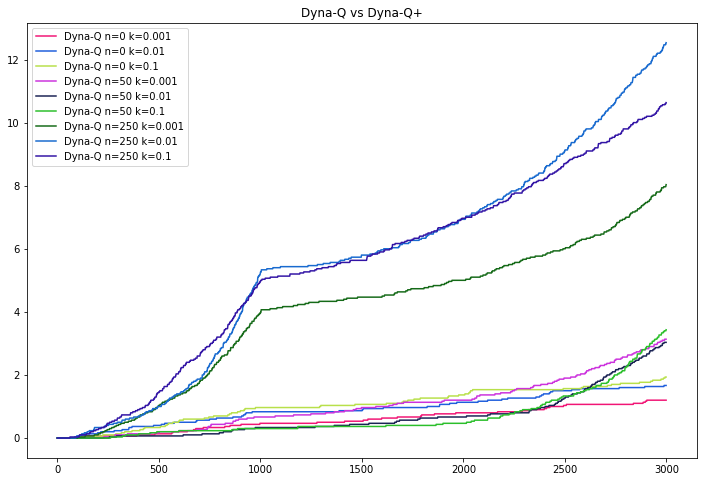

In [12]:
import matplotlib.pyplot as plt
from tqdm import tqdm


plt.figure(figsize=(12,8))

ns = [0, 50, 250]
ks = [0.001, 0.01, 0.1]

for n in ns:
    for k in ks:
        trials = 30
        data = []

        for trial in tqdm(range(trials)):
            agent = Agent()
            agent.reset()
            temp, _ = agent.dynaplus(k=k, n=n)
            data.append(temp)
        plt.plot(np.mean(np.array(data), axis=0), label="Dyna-Q n={} k={}".format(n,k), c=np.random.rand(3,))
            
plt.title("Dyna-Q vs Dyna-Q+")
plt.legend()